In [1]:
%reset -f
import numpy as np
from landlab import RasterModelGrid
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
colors = [(0,0,1,i) for i in np.linspace(0,1,3)]
WaterMap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=2)

#Hillshading
from matplotlib.colors import LightSource

#VideoMaking
import imageio

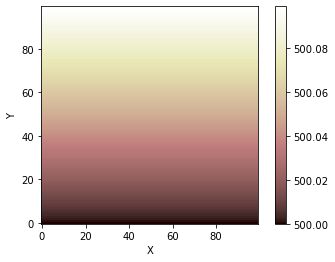

In [2]:
#Define grid
nX = 100
nY = 100
spacing = 1.0
grid = RasterModelGrid((nX, nY), xy_spacing=1.)

## Topography ##
Datum = 500 
z = np.ones(nX*nY) * Datum
z = grid.add_field('topographic__elevation', z, at='node')

# Long. slope
Long_Slope = 1./1000
z += grid.node_y*Long_Slope

imshow_grid(grid,'topographic__elevation')

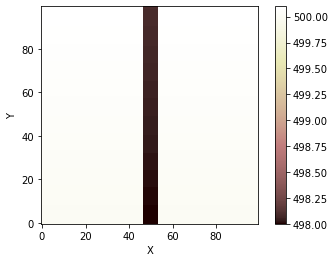

In [3]:
# Channel Indentation
Channel_Width = 8.
Channel_Depth = 2.

isChannel = (grid.node_x > nX/2 - Channel_Width/2) * (grid.node_x < nX/2 + Channel_Width/2)
z[isChannel] -= Channel_Depth
imshow_grid(grid,'topographic__elevation')

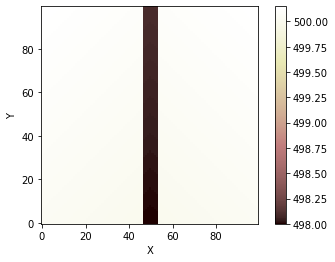

In [4]:
# Banks Slope
Transversal_Slope = 1./1000

z += np.abs(grid.node_x-(nX/2))*Transversal_Slope
imshow_grid(grid,'topographic__elevation')

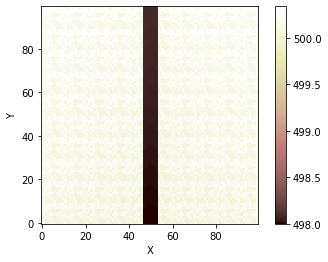

In [5]:
# Random noise
z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[10,10]),nX*nY) 
imshow_grid(grid,'topographic__elevation')

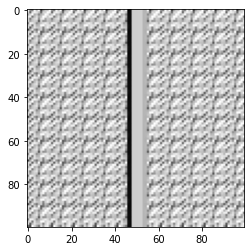

In [6]:
ls = LightSource(azdeg=315, altdeg=45)

plt.imshow(ls.hillshade(np.reshape(z,[100,100]), vert_exag=10), cmap='gray')
plt.show()

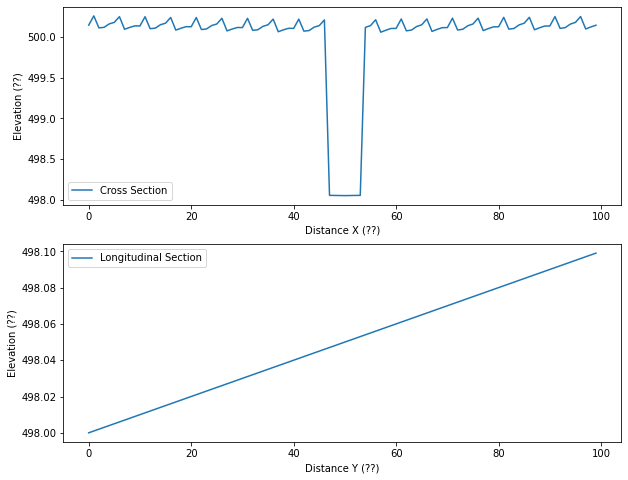

In [7]:
fig = plt.figure(figsize=(10,8))

## Cross Section
ax1 = plt.subplot(2,1,1)
ax1.plot(grid.node_x[grid.node_y==nY/2],z[grid.node_y==nY/2],label="Cross Section")
ax1.set_ylabel("Elevation (??)")
ax1.set_xlabel("Distance X (??)")
ax1.legend()

## Long Section
ax2 = plt.subplot(2,1,2)
ax2.plot(grid.node_y[grid.node_x==nX/2],z[grid.node_x==nX/2],label="Longitudinal Section")
ax2.set_ylabel("Elevation (??)")
ax2.set_xlabel("Distance Y (??)")
ax2.legend()

fig.show()

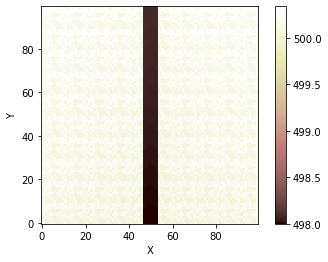

In [8]:
imshow_grid(grid,'topographic__elevation')

In [9]:
#Cast water depth values
#Pointer to water depth
h = np.zeros(100*100)
bools = (grid.node_x > nX/2 - Channel_Width/2) * (grid.node_x < nX/2 + Channel_Width/2) * (grid.node_y >= 95)
h[bools] = Channel_Depth*2
h = grid.add_field('surface_water__depth', h, at='node')

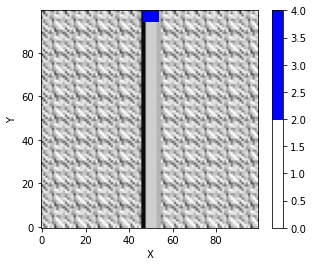

In [10]:
fig = plt.figure(figsize=(5,4))
plt.imshow(ls.hillshade(np.reshape(z,[100,100]), vert_exag=10), cmap='gray',origin="lower")
imshow_grid(grid,'surface_water__depth',cmap=WaterMap)
fig.show()

In [11]:
#Call overland flow model
of = OverlandFlow(grid, steep_slopes=True)
of.run_one_step()

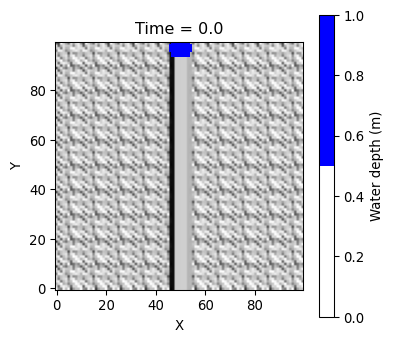

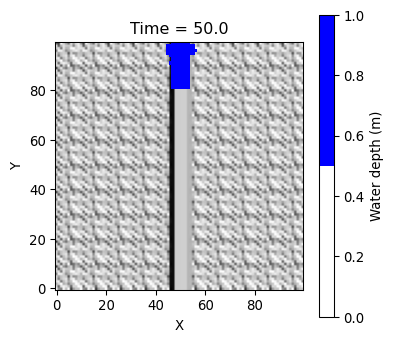

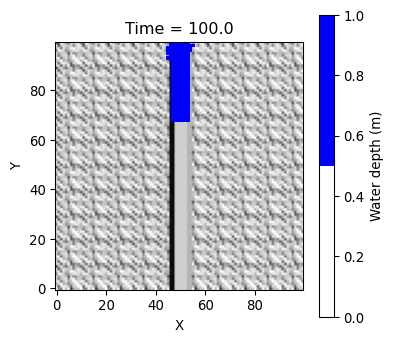

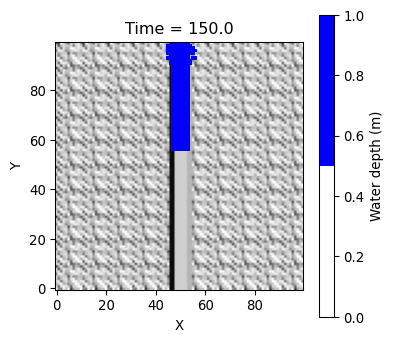

In [12]:
mydpi = 96
sizeFigure = 400

for t in range(200):
    of.run_one_step()
    
    if t%50==0:
        fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
        plt.imshow(ls.hillshade(np.reshape(z,[100,100]), vert_exag=10), cmap='gray',origin="lower")
        imshow_grid(grid,'surface_water__depth',\
                    limits=(0,1),cmap=WaterMap,\
                    colorbar_label="Water depth (m)",\
                    plot_name="Time = %.1f" %t)
        fig.savefig("ResultImages/%i.png" %t)